# Лабораторная работа №1 
Выполнила Титова Анастасия, 520 группа.

## Постановка задачи

Разработать программу, которая обеспечивает работу с изображениями карточек игрового набора <<Геометрика>>. Реализовать ввод и отображение на экране изображений, сегментацию изображений на  основе  точечных  и  пространственных преобразований, выделение и распознавание изображений фигур на карточках (определить тип фигуры, количество вершин и выпуклость, в случае, если фигура является многоугольником).

В задание входят следующие задачи на изображениях разной сложности:

1. Определить количество карточек на изображении: 
    - карточки изолированные 
    - карточки накладываются друг на друга. 
2. Определить фигуру на карточке: 
    - определить тип фигуры - многоугольник или фигура с гладкой границей 
    - для многоугольников определить количество вершин 
    - определить, является ли многоугольник выпуклым. 
    
    
Обе задачи ставятся в двух вариантах: с белым фоном (#) и с пестрым фоном (&).

Сложность задач соответствует трём классам: Beginner, Intermediate, Expert. 
+ Класс Beginner: 1А# и (1Б&  или 1Б#). 
+ Класс Intermediate: [1А# и (1Б&  или 1Б#) ] и 2А# и 2Б# и 2В#. 
+ Класс Expert: [1А# и (1Б&  или 1Б#) ] и [2А# и 2Б# и 2В#] и [2А& и 2Б& и 2В&]. 

**В разработанной программе реализовано решение задачи класса Expert:**

* ввод и отображение на экране изображений; 
* сегментация  изображений  на  основе  точечных  и  пространственных преобразований; 
* выделение и распознавание изображений фигур на карточках; 
* определение типа фигуры - многоугольник или фигура с гладкой границей; 
* для многоугольников определяет количество вершин;
* определяет, является ли многоугольник выпуклым; 
* производит маркировку карточек, в соответствии с определенными выше характеристиками фигур, изображенных на них;

– для любой сложности изображения (для произвольного взаимного расположения карточек и типа фона).

Входом программы являются изображения в формате JPG.
Выход программы: для первой задачи – исходное изображение с нанесенной на нём нумерацией карточек, для второй – разметкой результата маркерами PnC или Pn: 
P – многоугольник, n – число вершин многоугольника, C – выпуклый многоугольник 

## Описание данных
Алгоритм программы был отлажен и обучен на приложенном к заданию наборе из 7 изображений различной сложности в формате JPG. Сложность изображения определяется
а) количеством карточек
б) их взаимным расположением
в) сложностью фона (белый или пёстрый)

Карточки хаотично расположены на фоне, цвет карточек – синий, на карточках изображены геометрические фигуры, а также предметы: циркули, транспортиры ластики, мелки и прочее.

## Описание программной реализации, метода решения и результатов экспериментов



### Импорт необходимых для решения задачи библиотек и компонент

In [1]:
import numpy as np
import cv2
import math
import PIL
from PIL import ImageFont, Image, ImageDraw
from skimage import data
from skimage import io
from skimage import color
from skimage import filters
from skimage import exposure
from skimage import feature
from skimage import restoration
from skimage import img_as_ubyte
from skimage import measure
from matplotlib import cm
from skimage import morphology as m
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
%matplotlib inline

### Определим следующие функции:

#### Вывод изображения на экран

In [2]:
def showim(image, cm=None): #Show image
    fig = plt.figure(figsize = (13,13))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap=cm)    

#### Отрисовка текста на заданной позиции

In [3]:
def draw_text(im4t, coords, text):
    font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSansBold.ttf",size=22)
    draw = ImageDraw.Draw(im4t)
    draw.text(coords, text,(255,255,0), font=font)
    draw = ImageDraw.Draw(im4t)

#### Создание маски для проведения операции выделения границ

Для реализации этой функции используются средства библиотеки skimage.
В функцию в качестве аргументов передаются изображение и флаг: True - если изображение с пестрым фоном, False - если с белым.
Изображение переводится в формат hsv (hue, saturation, value) и бинаризуется по экспериментально подобранным порогам. Задача создания маски - отделить фон и посторонние элементы на карточках от карточек и изображённых на них фигур.
В случае белого фона, достаточно было подобрать подходящие пороги и воспользоваться морфологическими операциями skimage для удаления шума (была использована реализация функции удаления мелких отверстий remove_small_holes).

Для пёстрого фона, маска формировалась сложнее, итоговая маска является побитовым И следующих масок: 
* маска 1: для её формирования производится выделение карточек и удаление шума (удаление мелких объектов и отверстий)
* маска 2: уточнение "лишних" элементов карточек (транспортиры, ластики, циркули) и фона (полосы на ткани) и удаление шума
* маска 3: уточнение "лишних" элементов карточек (мелки, засвеченные области карточек) и удаление шума

Итоговая маска, сформированная в результате выполнения функции, выводится на экран.

In [4]:
#Create mask for edge detection 
#True - complex background, False - simple background
def create_mask(img, flag = False):
    img_hsv = color.rgb2hsv(img)
    if (flag):
        mask1 = (img_hsv[:,:,0]>0.3) & (img_hsv[:,:,0]<0.7)
        mask1 = m.remove_small_holes(mask1)
        mask1 = m.remove_small_objects(mask1)
        mask2 = ~(img_hsv[:,:,0]<0.2)
        mask2 = m.remove_small_holes(mask2)
        mask3= (img_hsv[:,:,1]>0.1)
        mask3 = m.remove_small_holes(mask3)
        mask4=mask1&mask2&mask3
    else:
        mask = (img_hsv[:,:,1]>0.3)&(img_hsv[:,:,0]>0.3)
        mask4 = m.remove_small_holes(mask,min_size=50)
    showim(mask4, 'gray')
    return mask4

#### Подсчёт карточек

Для реализации этой функции используются средства библиотеки skimage. В функцию в качестве аргументов передаются путь изображения и флаг: True - если изображение с пестрым фоном, False - если с белым.
Для подсчёта карточек реализовано выделение фигур, изображенных на карточках, и далее считается именно количество выделенных фигур. Выбор такого подхода основан на том, что а) выделение и разделение пересекающихся карточек по границам карточек не удалось (были реализованы и опробованы различные алгоритмы, в том числе рассматривалось применение distance transform и watershed алгоритмов) б) для выполнения задач класса сложности Intemediate и Expert необходимо выполнять выделение фигур в) между фигурами и карточками можно установить взаимно однозначное соответствие.


Функция считывает изображение в переменную, далее вызывается функция создания маски, отделяющей фон от карточек, описанная выше. 

Изображение, переведённое в grayscale, передаётся в функцию canny, реализующую детектор границ Кэнни.

В реализации библиотеки skimage алгоритм имеет несколько основных этапов:
* *Сглаживание*: на данном этапе происходит размытие изображения для удаления шума. Для этого воспользуемся размытием изображения фильтром Гаусса. В результате экспериментов, был подобран параметр фильтра $\sigma = 1.7$.
* *Поиск градиентов*: Границы отмечаются там, где градиент изображения приобретает максимальное значение.  В библиотеке skimage реализация метода использует вертикальный и горизонтальный операторы Собеля, толщина границы - норма градиента.
* Далее потенциальные границы уточняются и "утончаются" до кривой толщиной в 1 пиксель. Сначала находят нормали к границе в каждой точке, в соответсвии со знаком и относительной величиной X-Собеля и Y-Собеля точки разделяются на 4 категории: горизонтальные, вертикальные, диагональные и анти-диагональные. Далее просматриваются значения в направлениях нормали и обратном направлении относительно рассматриваемой точки (больше ли они). И используется интерполяция, чтобы получить "смесь" значений в точках, а не использовать только значение в точке, которая расположена ближе всех к нормали.
* *Двойная пороговая фильтрация*: сначала все точки, со значением выше порогового, отмечаются как точки границы. Далее рекурсивно помечаются как точки границы все точки со значением выше нижнего порога, которые связаны с точками границы по одному из 8 направлений.

В результате работы алгоритма мы получаем изображение с границами фигур, изображённых на карточках, и некоторым шумом – границы предметов на карточках, которые не удалось убрать с помощью маски.

Далее производится ряд морфологических операций для уточнения границ и избавления от шума: дилатация для соединения контуров, удаление мелких объектов для удаления контуров посторонних предметов, далее области заполняются с помощью функции binary_fill_holes и, так как размер нужных нам областей значительно превосходит размер областей случайных контуров, можем убрать тот шум, которые не удалось удалить на предыдущих этапах.

Далее применяем эрозию для получения более четких границ областей, убираем остаточный шум и выделяем связные компоненты.

Для выделения и подсчета связных компонент используется функция label из библиотеки skimage. В этой реализации используются модификации алгоритмов выделения связных компонент, предложенные в статье *Wu, KeshengOtoo, EkowShoshani, Arie* Optimizing connected component labeling algorithms, 2005: https://escholarship.org/uc/item/7jg5d1zn

Далее для разметки карточек на изображении вызвается функция draw_text, описанная выше. Полученное изображение записывается в файл "marked_image1.jpg".

In [5]:
#Count cards by detecting figures
def count_cards(img_path, flag):
    img = io.imread(img_path)
    img_gray = color.rgb2gray(img)
    #creating mask for edge detection
    mask = create_mask(img, flag)
    #Canny's edge detection
    edges = feature.canny(img_gray, sigma=1.7, mask=mask)
    #adjusting image: refining edges, erasing small edges/objects, filling small contours to remove them
    edges2 = m.dilation(edges)
    edges3 = m.remove_small_objects(edges2,150)
    filled = ndi.binary_fill_holes(edges3)
    newfin = m.remove_small_objects(filled, 300)
    #erode objects to get sharpen edges
    newfin= m.erosion(newfin,m.square(6))
    #once again erasing small objects
    newfin = m.remove_small_objects(newfin, 300)
    #label areas and count them
    labelled, num = measure.label(newfin, return_num=True)
    showim(img)
    showim(labelled)
    im4t = Image.open(img_path)
    for l in np.unique(labelled):
        if(l>0):
            i, j = np.where(labelled == l)
            draw_text(im4t, (j[0]-15,i[0]), "№"+str(l))
        
    im4t.save("marked_image1.jpg")
    return num, newfin

#### Выделение фигур и определение их свойств

Для реализации этой функции использовались средства библиотеки OpenCV. В качестве параметра в функцию передается изображение, полученное в результате выполнения функции count_cards.

Изображение приводится к формату, используемому в OpenCV, далее производится пороговая обработка изображения, и применяется функция findContours с режимом RETR_TREE(выделяет все контуры и восстанавливает полную иерархию) и методом аппроксимации CHAIN_APPROX_SIMPLE (сжимает горизонтальные, вертикальные и диагональные сегменты и оставляет только из конечные точки).
Далее, для каждого контура мы применяем функцию approxPolyDP, которая использует алгоритм Рамера-Дугласа-Пекера, чтобы приблизить контур, некоторым контуром с меньшим числом точек. В ходе экспериментов, оптимальной была выбрана точность приблежения $0.017 * P$, где $P$ – периметр исходного контура.

За количество углов рассматриваемой фигуры примем количестов точек контура, полученного в результате аппроксимации.
Рассмотрим взаимное расположение этих точек. Проанализировав различные характеристики контуров фигур с карточек набора, можем сделать вывод, что при любом положении карточки на плоскости расстояние между точками многоугольника с количеством вершин менее $10$ должно превосходить $12$. Однако в силу нечеткости границ, возникают "лишние" углы. Следовательно, обнаружив многоугольник с такими характеристиками, уменьшим количество его вершин на $1$. Удалять саму точку из контура не обязательно, т.к. это незначительно влияет на остальные характеристики.
Далее для каждого контура находим его характеристики, которые будем использовать для определения свойств фигуры на карточке: периметр, площадь, отношение сторон прямоугольника, в который вписана фигура, и отношение площади области, ограниченной контуром, к площади выпуклой оболочке задающих его точек.

В ходе экспериментов, было обнаружено, что все фигуры с гладкой границой аппроксимируются не менее, чем $7$ точками, следовательно, все фигуры с меньшим количеством вершин можем определить как многоугольники.
Далее, среди фигур с $7$ и более вершинами, разница между площадью области, ограниченной аппроксимированным контуром с меньшим количеством точек, и площадью области, ограниченной исходным контуром, превышает пороговое значение $168$ лишь у фигур с гладким контуром.

Далее проверяем выпуклость фигуры, ограниченной контуром, с помощью вычисления solidity -- отношение площади области, ограниченной контуром, к площади выпуклой оболочке задающих его точек. Для отсечения невыпуклых фигур был выбран порог $0.94$.

Однако было обнаружено, что в некоторых ракурсах, невыпуклая фигура с гладкой границей, аппроксимируемая $8$ вершинами, не удовлетворяет пороговому значению $168$. В качестве временного решения для определения данной фигуры было выбрано значение отношения сторон прямоугольника, в который вписана фигура. Т.к. в предложенном для отладки и обучения наборе было лишь $2$ невыпуклые фигуры, аппроксимируемые $8$ вершинами, при этом обладающие ярковыраженными различиями в протяженности. Для дальнейшего выделения фигуры с гладкой границей, для этого отношения был выбран порог $0.9$. Данный выбор признака не является оптимальным, но на момент отправления отчёта более эффективные признаки для классификации фигур установить не удалось.

В процессе определения характеристик фигур формируется результирующая строка "res", содержащая маркировку для карточки, в соответсвии с постановкой задачи. Далее строка передаётся в функцию draw_text,  Полученное изображение записывается в файл "marked_image2.jpg".

In [6]:
#classify objects and mark them accordingly:
#P - if a polygon, n - number of vertices, C - if polygon is convex
def mark_cards(img, img_path):
    #transferring to OpenCV format
    cv_im = img_as_ubyte(img)
    #open image for drawing text
    im4t = Image.open(img_path)
    #finding contours
    ret,thresh = cv2.threshold(cv_im,0,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        res = "" #resulting string variable
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.017 * peri, True)
        corners = len(approx)
        
        #delete point if it is too close to the previous (if there are less than 10 vertices)
        #we are not deleting the point itself from an array since it doesn't make much of a difference
        #we are just decreasing the "corners" counter
        for i, point in enumerate(approx):
            if i > 0:
                prev_i = i - 1
            else:
                prev_i = len(approx)-1
                
            previous = approx[prev_i]
            y1 = point.item(1) - previous.item(1)
            x1 = point.item(0) - previous.item(0)
            if ((corners<10) & (math.sqrt(x1**2 + y1**2)<12)):
                corners = corners-1
        #calcuating some contour properties for classification
        perimeter = cv2.arcLength(c,True)
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w)/h
        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        areaCORN =  cv2.contourArea(approx)
        #all our non-polygons tend to have >=7 vertices, so if there are less than 7 verticies it is a polygon
        if (corners<7):
            res = "P"+res+ str(corners)
        else:
            #most of our non-polygons can be detected by the difference between their initial contour area and 
            #and area of a polygon, built on approximated vertices
            if ((area-areaCORN < 168)):
                res = "P"+res+ str(corners)
        #checking for convexity
        if(solidity>0.94):
            if(res!=""):
                res=res+"C"
        else:
            #However it is hard to distinguish non-convex polygon with 8 verticies and non-convex non-polygon
            #whose contour was approximated with 8 vertices.
            #In our case the ratio of width to height of bounding rect of the object helps to destinguish between these two.
            if (corners==8)&(aspect_ratio>0.9):
                res=""
        draw_text(im4t, (approx[0].item(0)-18, approx[0].item(1)),res)
        draw = ImageDraw.Draw(im4t)
    im4t.save("marked_image2.jpg")
    return 

## Пример работы программы

В примерах ниже программа выводит:
* Количество карточек на изображении
* Маску изображения, полученную в функции create_mask
* Исходное изображение
* Изображение с выделенными в разные области фигурами
* Результат выполнения части 1 задания - изображение, с нанесёнными на карточки номерами
* Результат выполнения части 2 (уровень Expert) задания - изображение, с нанесённой на карточки маркировкой

#### Изображение с пёстрым фоном

Количество карточек на изображении: 21


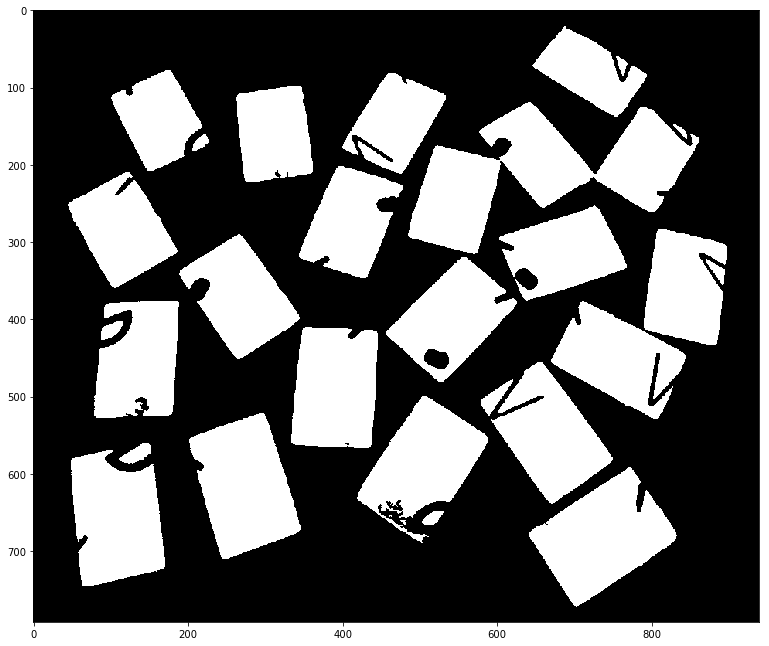

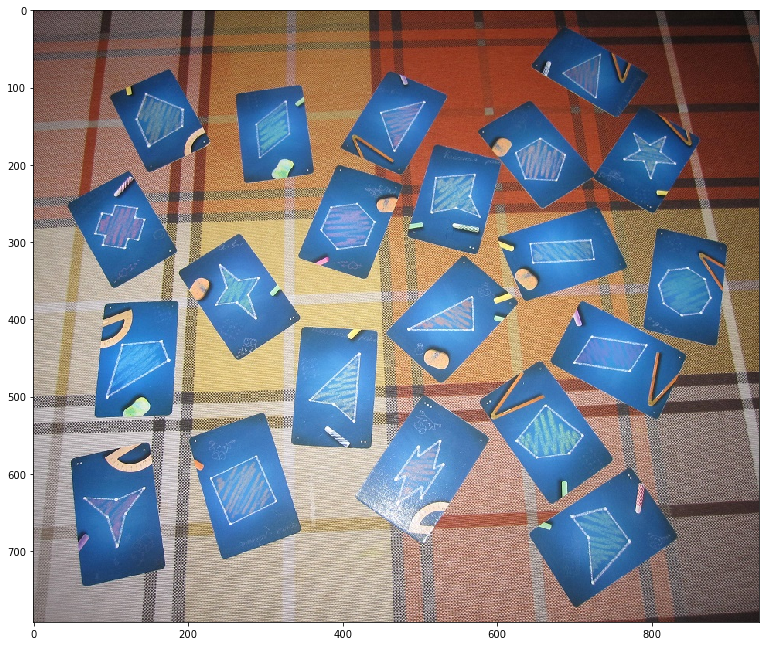

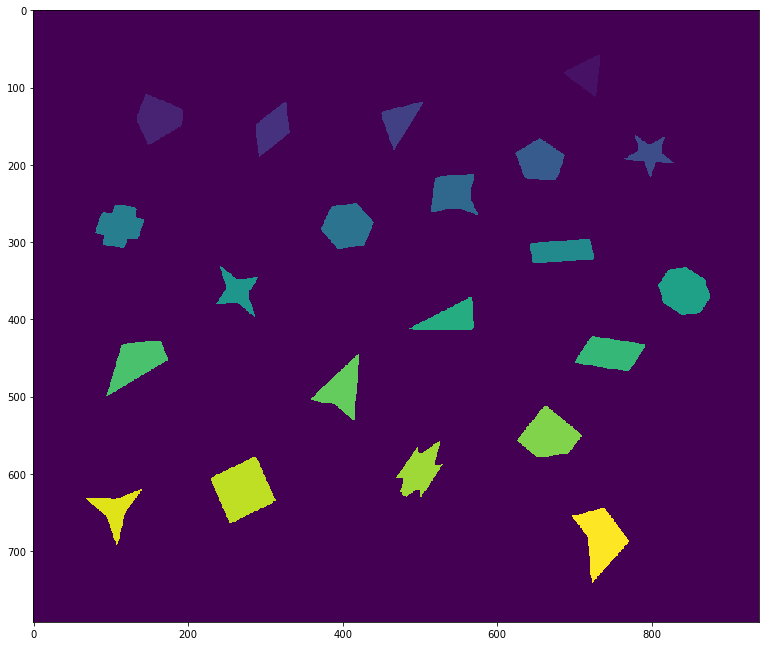

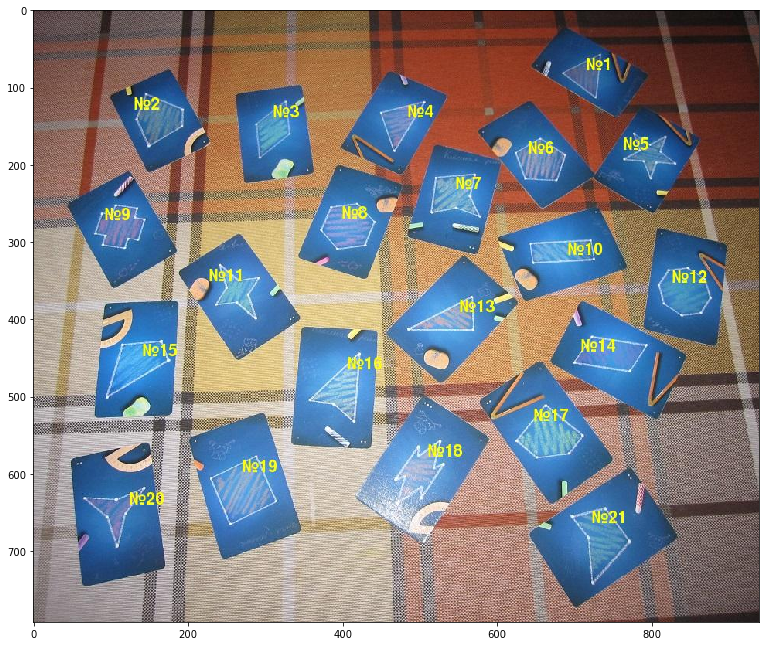

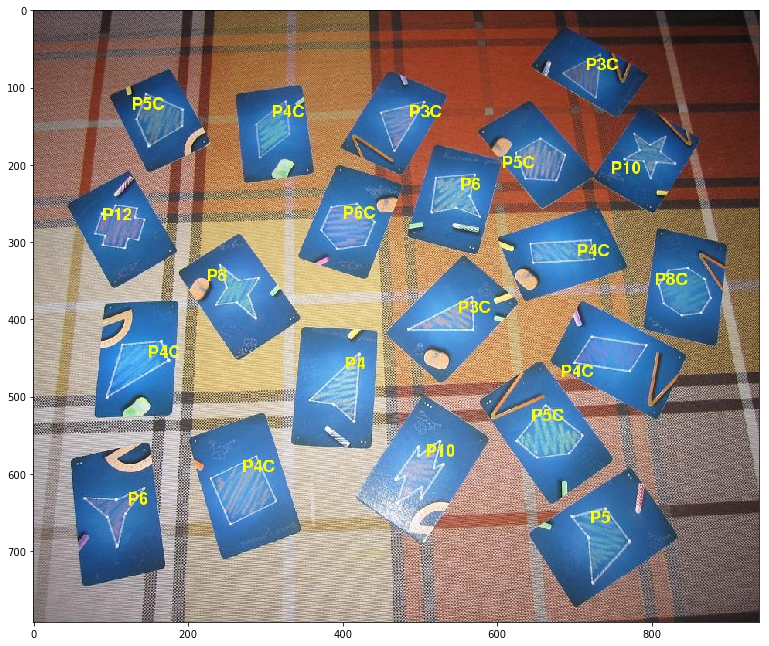

In [7]:
img_path = "./Obraztsy/IMG_9.jpg"
num, img = count_cards(img_path, True)
mark_cards(img, img_path)
print("Количество карточек на изображении:", num)
showim(cv2.cvtColor(cv2.imread("marked_image1.jpg"), cv2.COLOR_BGR2RGB))
showim(cv2.cvtColor(cv2.imread("marked_image2.jpg"), cv2.COLOR_BGR2RGB))

#### Изображение с белым фоном

Количество карточек на изображении: 25


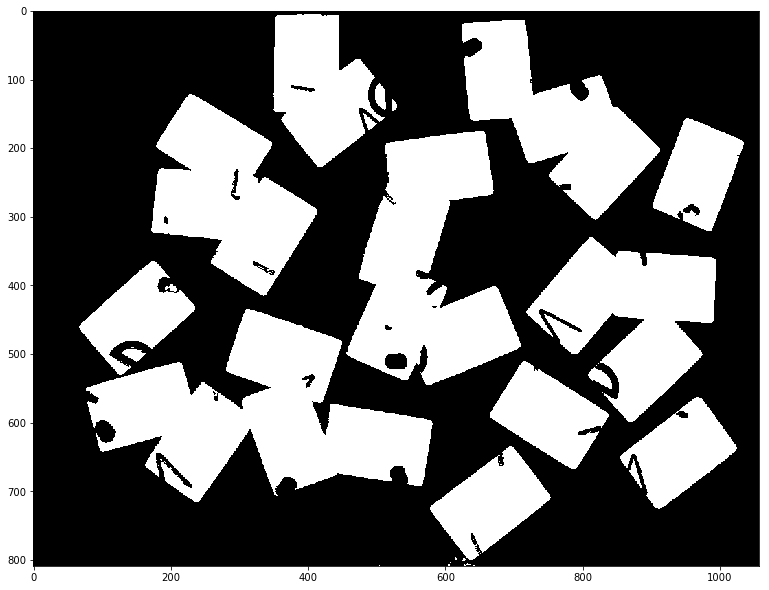

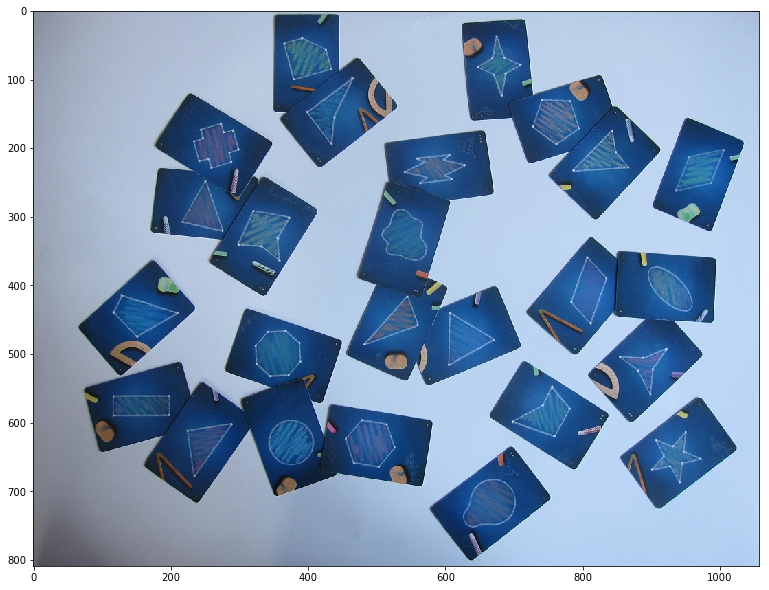

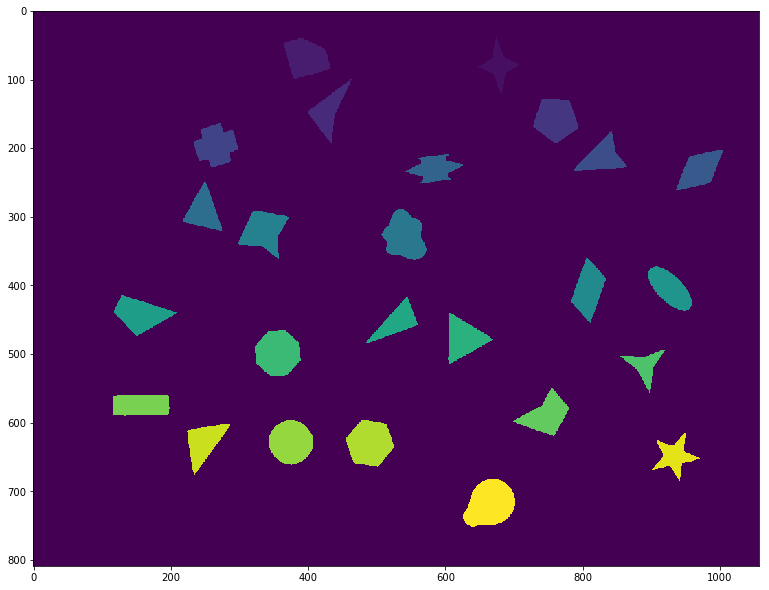

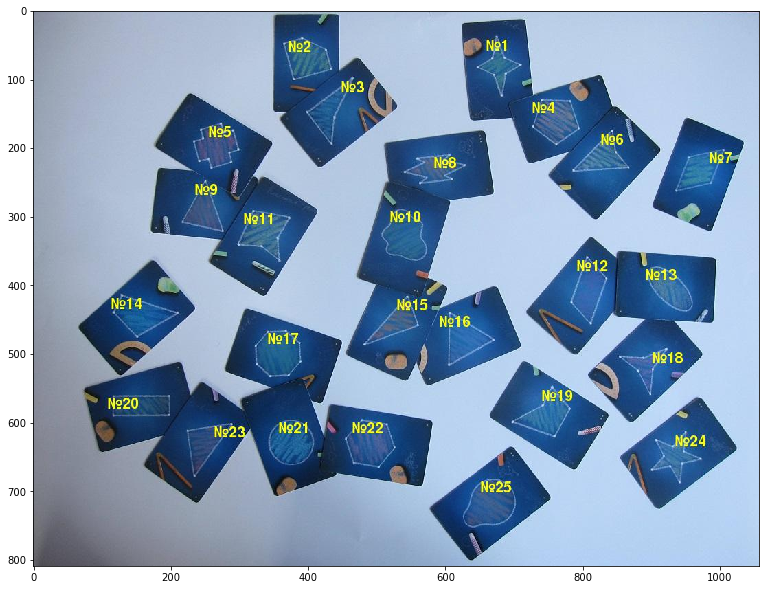

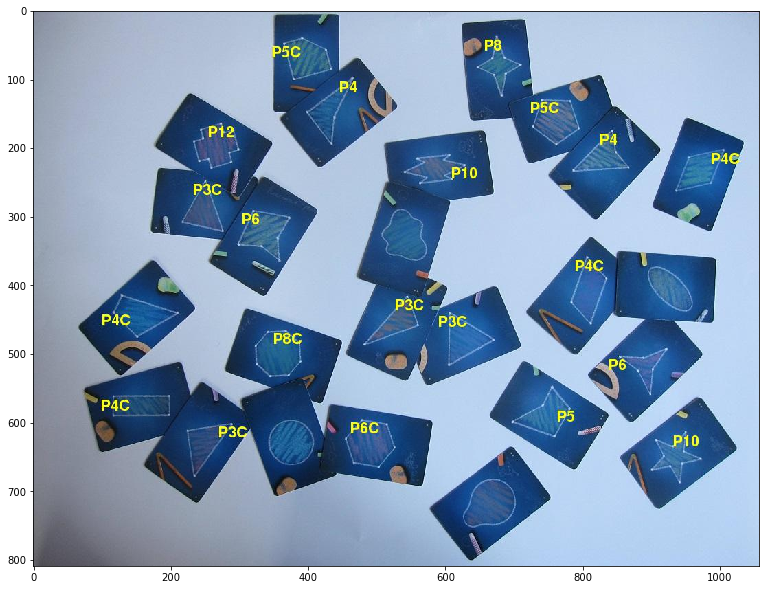

In [8]:
img_path = "./Obraztsy/IMG_4.jpg"
num, img = count_cards(img_path, False)
mark_cards(img, img_path)
print("Количество карточек на изображении:", num)
showim(cv2.cvtColor(cv2.imread("marked_image1.jpg"), cv2.COLOR_BGR2RGB))
showim(cv2.cvtColor(cv2.imread("marked_image2.jpg"), cv2.COLOR_BGR2RGB))

## Описание экспериментов и выводы

В ходе реализации было испробовано множество алгоритмов и методов обработки изображений. Была сделана попытка  добавить этап предобработки изображения (нормализация гистаграммы яркости, медианный фильтр, билатеральный фильтр, использование гауссовой фильтрации (т.к. применяется в ходе выделения границ Кэнни, этот фильтр был убран)), однако не удалось подобрать метод, который бы давал улучшение на всех изображениях.
Как было описано выше, в начале была произведена попытка разделить и посчитать карточки, основываясь на из собственных границах с использованием алгоритма distance transform. Также, в ходе освоения различных библиотек и подборов порогов бинаризации были опробованы различные методы вычисления порога (например, метод Оцу).
Был проведён анализ множества характеристик контуров, для выделения тех, которые могли бы послужить основными признаками для классификации фигур.

Дальнейшее улучшение текущей реализации программы можно проводить в трёх направлениях:
1. *Улучшение границ*. Подобрать подходящую предобработку изображения для избавления от шума, повышения чёткости, и, возможно, применение геометрических преобразований, для сглаживания искажений, обусловленных ракурсом съемки. Этой же цели может послужить более качественный подбор порогов бинаризации. При успешном выполнении этих улучшений, удастся снизить количество морфологических преобразований, которым подвергается изображение после бинаризации, а значит и границы будут сохранены лучше, вероятно удастся избавиться от "лишних" точек в многоугольниках.
2. *Подбор признаков*. Продолжить исследование характеристик контуров для выявление более эффективных решающих правил для классификации.
3. *Повышение производительности программы*.